In [2]:
from google.colab import drive, files

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # matplotlib.pyplot plots data
%matplotlib inline 
import seaborn as sns
sns.set(color_codes=True)

from zipfile import ZipFile
import os
from matplotlib.patches import Rectangle

!pip install -q pydicom
import pydicom as dcm
from glob import glob
from tqdm import tqdm_notebook

     |████████████████████████████████| 1.9MB 4.0MB/s 


In [3]:
!pip install --upgrade --force-reinstall --no-deps kaggle
files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c rsna-pneumonia-detection-challenge

     |████████████████████████████████| 61kB 2.1MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-cp37-none-any.whl size=73053 sha256=d89a5c2b517c7cf3a858d9ec416ab9257291f915326f43ffbd903dd41f019d89
  Stored in directory: /root/.cache/pip/wheels/a1/6a/26/d30b7499ff85a4a4593377a87ecf55f7d08af42f0de9b60303
Successfully built kaggle
  Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


Saving kaggle.json to kaggle.json
100% 3.65G/3.66G [00:46<00:00, 39.5MB/s]
100% 3.66G/3.66G [00:46<00:00, 85.1MB/s]


In [4]:
file_name = 'rsna-pneumonia-detection-challenge.zip'
datafile = ZipFile(file_name, 'r')
datafile.extractall()

In [5]:
data_folder = '/content/'

train_labels = pd.read_csv(data_folder + 'stage_2_train_labels.csv')
class_info = pd.read_csv(data_folder +'stage_2_detailed_class_info.csv')

print(f'Train Labels has {train_labels.shape[0]} rows and {train_labels.shape[1]} columns')
print(f'Class info has {class_info.shape[0]} rows and {class_info.shape[1]} columns')
print('Train Labels # of patientID duplicates: {}'.format(len(train_labels) - (train_labels['patientId'].nunique())))
print('Class Info # of patientID duplicates: {}'.format(len(class_info) - (class_info['patientId'].nunique())))

Train Labels has 30227 rows and 6 columns
Class info has 30227 rows and 2 columns
Train Labels # of patientID duplicates: 3543
Class Info # of patientID duplicates: 3543


Printing the first few rows of "Train Labels" and "Class Info"

In [6]:
print('Train labels :\n'); display(train_labels.head(10))
print('\nClass info :\n'); display(class_info.head(10))

Train labels :



,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1
6,00569f44-917d-4c86-a842-81832af98c30,NaN,NaN,NaN,NaN,0
7,006cec2e-6ce2-4549-bffa-eadfcd1e9970,NaN,NaN,NaN,NaN,0
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1



Class info :



,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity
5,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity
6,00569f44-917d-4c86-a842-81832af98c30,No Lung Opacity / Not Normal
7,006cec2e-6ce2-4549-bffa-eadfcd1e9970,No Lung Opacity / Not Normal
8,00704310-78a8-4b38-8475-49f4573b2dbb,Lung Opacity
9,00704310-78a8-4b38-8475-49f4573b2dbb,Lung Opacity


Checking for nulls in bounding boxes and value counts for targets

In [7]:
print('Checking nulls in bounding boxes columns: {}'.format(train_labels[['x', 'y', 'width', 'height']].isnull().sum().to_dict())) 
print('Checking value counts for the targets: {}'.format(train_labels['Target'].value_counts().to_dict()))

Checking nulls in bounding boxes columns: {'x': 20672, 'y': 20672, 'width': 20672, 'height': 20672}
Checking value counts for the targets: {0: 20672, 1: 9555}


Checking  distribution of 'Target' and 'Class' columns

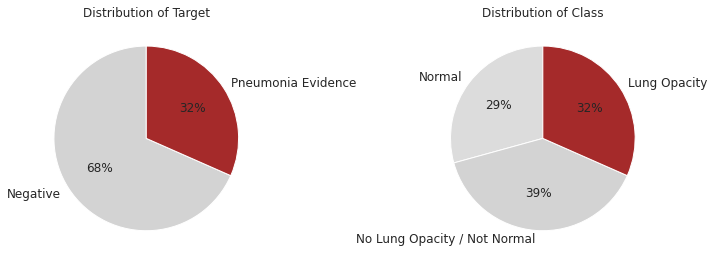

In [8]:
fig = plt.figure(figsize = (10, 6))
ax = fig.add_subplot(121)
g = (train_labels['Target'].value_counts()
    .plot(kind = 'pie', autopct = '%.0f%%', 
          labels = ['Negative', 'Pneumonia Evidence'], 
          colors = ['lightgray', 'brown'], 
          startangle = 90, 
          title = 'Distribution of Target', fontsize = 12)
    .set_ylabel(''))
ax = fig.add_subplot(122)
g = (class_info['class'].value_counts().sort_index(ascending = False)
    .plot(kind = 'pie', autopct = '%.0f%%', 
          colors = ['gainsboro', 'lightgray', 'brown'], 
          startangle = 90, title = 'Distribution of Class', 
          fontsize = 12)
    .set_ylabel(''))
plt.tight_layout()

Grouping by patient and checking number of bounding boxes for every unique patient

In [9]:
bounding_boxes = train_labels.groupby('patientId').size().to_frame('number_of_boxes').reset_index()
train_labels = train_labels.merge(bounding_boxes, on = 'patientId', how = 'left')
print('Number of unique patient ids: {}'.format(len(bounding_boxes)))
print('\nNumber of patient ids per bounding boxes')
(bounding_boxes.groupby('number_of_boxes')
.size()
.to_frame('number_of_patient_ids_per_boxes')
.reset_index()
.set_index('number_of_boxes')
.sort_values(by = 'number_of_boxes'))

Number of unique patient ids: 26684

Number of patient ids per bounding boxes


,number_of_patient_ids_per_boxes
number_of_boxes,
1,23286
2,3266
3,119
4,13


Let's check how each patientId is mapped to the class type

In [10]:
print('Each patient Id is associated with {} class'.format(class_info.groupby(['patientId'])['class'].nunique().max()))

Each patient Id is associated with 1 class


Merging "Train Labels" and "Class Info"

In [11]:
train_class = pd.concat([train_labels, class_info['class']], axis = 1)
print('Shape of the dataset after the merge: {}'.format(train_class.shape))

Shape of the dataset after the merge: (30227, 8)


Analysis based on reading of images

In [12]:
train_imgs = os.path.join(data_folder + 'stage_2_train_images/')
test_imgs = os.path.join(data_folder + 'stage_2_test_images/')

sample_patient_id = train_labels['patientId'][0]
dcm_file = train_imgs + '{}.dcm'.format(sample_patient_id)
dcm_data = dcm.read_file(dcm_file)

print(dcm_data)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 202
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time      

We will read the training images file names and path, determine the total number of images and observe the features of this data set

In [13]:
images = pd.DataFrame({'path': glob(os.path.join(train_imgs, '*.dcm'))})
images['patientId'] = images['path'].map(lambda x: os.path.splitext(os.path.basename(x))[0])
print('There are ',images.shape[0],'images in the training folder')
print('The columns ',list(images.columns),'are present in the training images dataframe')
assert images.shape[0] == len(list(set(train_class['patientId']))), 'Number of training images should be equal to the unique patientIds we have'

There are  26684 images in the training folder
The columns  ['path', 'patientId'] are present in the training images dataframe


Let us merge the image dataframe that we read just now and the 'Train Class' dataframe read earlier, using 'Patient Id' as the key 

In [14]:
train_class = train_class.merge(images, on = 'patientId', how = 'left')
print('Shape of the `train_class` dataframe after merge: {}'.format(train_class.shape))
del images

Shape of the `train_class` dataframe after merge: (30227, 9)


Get features from the training images and save the feature engineered dataframe for future use

In [15]:
# Helper function to get additional features from dicom images
def get_tags(data, path):
    images = os.listdir(path)
    for _, name in tqdm_notebook(enumerate(images)):
        img_path = os.path.join(path, name)
        img_data = dcm.read_file(img_path)
        idx = (data['patientId'] == img_data.PatientID)
        data.loc[idx,'PatientSex'] = img_data.PatientSex
        data.loc[idx,'PatientAge'] = pd.to_numeric(img_data.PatientAge)
        data.loc[idx,'BodyPartExamined'] = img_data.BodyPartExamined
        data.loc[idx,'ViewPosition'] = img_data.ViewPosition
        data.loc[idx,'Modality'] = img_data.Modality


In [16]:
print('Get features such as {} from training images'.format(('PatientSex', 'PatientAge', 'BodyPartExamined', 'ViewPosition', 'Modality')))
get_tags(train_class, train_imgs)

Get features such as ('PatientSex', 'PatientAge', 'BodyPartExamined', 'ViewPosition', 'Modality') from training images


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [17]:
out_dir = os.path.join('./output/')
if not os.path.exists(out_dir): os.makedirs(out_dir)

train_class.to_pickle('./output/train_feature_engineered.pkl')

Let us load the consolidated data set and observe its shape

In [18]:
train_class = pd.read_pickle('./output/train_feature_engineered.pkl')
train_class.shape

(30227, 14)

In [19]:
train_class.head()

,patientId,x,y,width,height,Target,number_of_boxes,class,path,PatientSex,PatientAge,BodyPartExamined,ViewPosition,Modality
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,1,No Lung Opacity / Not Normal,/content/stage_2_train_images/0004cfab-14fd-4e...,F,51.0,CHEST,PA,CR
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,1,No Lung Opacity / Not Normal,/content/stage_2_train_images/00313ee0-9eaa-42...,F,48.0,CHEST,PA,CR
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,1,No Lung Opacity / Not Normal,/content/stage_2_train_images/00322d4d-1c29-49...,M,19.0,CHEST,AP,CR
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,1,Normal,/content/stage_2_train_images/003d8fa0-6bf1-40...,M,28.0,CHEST,PA,CR
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,2,Lung Opacity,/content/stage_2_train_images/00436515-870c-4b...,F,32.0,CHEST,AP,CR


In [20]:
print('Unique `Body Parts Examined`: {}'.format(train_class['BodyPartExamined'].unique()[0]))
print('Unique `Modality`: {}'.format(train_class['Modality'].unique()[0]));

Unique `Body Parts Examined`: CHEST
Unique `Modality`: CR


Let us observe the distribution of `ViewPosition` when Target is 1
The distribution is almost the same, but where there's a Pneumonia Evidence `ViewPosition` is `AP`
AP: Anterior/Posterior, PA: Posterior/Anterior

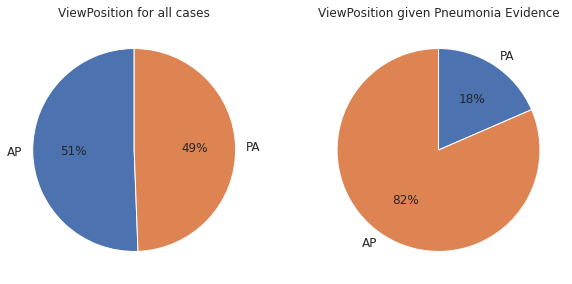

In [21]:
fig = plt.figure(figsize = (10, 6))
ax = fig.add_subplot(121)
g = (train_class['ViewPosition'].value_counts()
    .plot(kind = 'pie', autopct = '%.0f%%',  
          startangle = 90,
          title = 'ViewPosition for all cases', 
          fontsize = 12)
    .set_ylabel(''))
ax = fig.add_subplot(122)
g = (train_class.loc[train_class['Target'] == 1, 'ViewPosition']
     .value_counts().sort_index(ascending = False)
    .plot(kind = 'pie', autopct = '%.0f%%', 
          startangle = 90, counterclock = False, 
          title = 'ViewPosition given Pneumonia Evidence', 
          fontsize = 12)
    .set_ylabel(''))

Plot x and y centers of bounding boxes

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


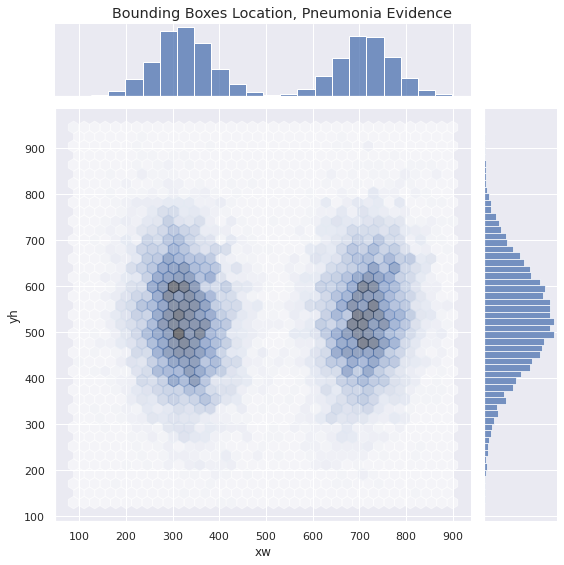

In [22]:
# Creating a dataframe with columns for center of the rectangles
bounding_boxes = train_class[train_class['Target'] == 1]
bounding_boxes['xw'] = bounding_boxes['x'] + bounding_boxes['width'] / 2
bounding_boxes['yh'] = bounding_boxes['y'] + bounding_boxes['height'] / 2

g = sns.jointplot(x = bounding_boxes['xw'], y = bounding_boxes['yh'], data = bounding_boxes, 
                  kind = 'hex', alpha = 0.5, height = 8)
plt.suptitle('Bounding Boxes Location, Pneumonia Evidence')
plt.tight_layout()
plt.subplots_adjust(top = 0.95)
plt.show()

Let us explore the bounding boxes centers for ViewPositions for a random sample

In [23]:
def bboxes_scatter(df1, df2, text1, text2):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (13, 8))
    fig.subplots_adjust(top = 0.85)
    fig.suptitle('Plotting centers of lung opacity\n{} & {}'.format(text1, text2))
    df1.plot.scatter(x = 'xw', y = 'yh', ax = ax1, alpha = 0.8, marker = '.', 
                   xlim = (0, 1024), ylim = (0, 1024), color = 'green')
    ax1.set_title('Centers of Lung Opacity\n{}'.format(text1))
    for i, row in df1.iterrows():
        ax1.add_patch(Rectangle(xy = (row['x'], row['y']),
                            width = row['width'], height = row['height'], 
                            alpha = 3.5e-3, color = 'yellow'))
    plt.title('Centers of Lung Opacity\n{}'.format(text2))
    df2.plot.scatter(x = 'xw', y = 'yh', ax = ax2, alpha = 0.8, marker = '.',
                   color = 'brown',  xlim = (0, 1024), ylim = (0, 1024))
    ax2.set_title('Centers of Lung Opacity\n{}'.format(text2))
    for i, row in df2.iterrows():
        ax2.add_patch(Rectangle(xy = (row['x'], row['y']),
                             width = row['width'], height = row['height'],
                             alpha = 3.5e-3, 
                             color = 'yellow'))
    plt.show()

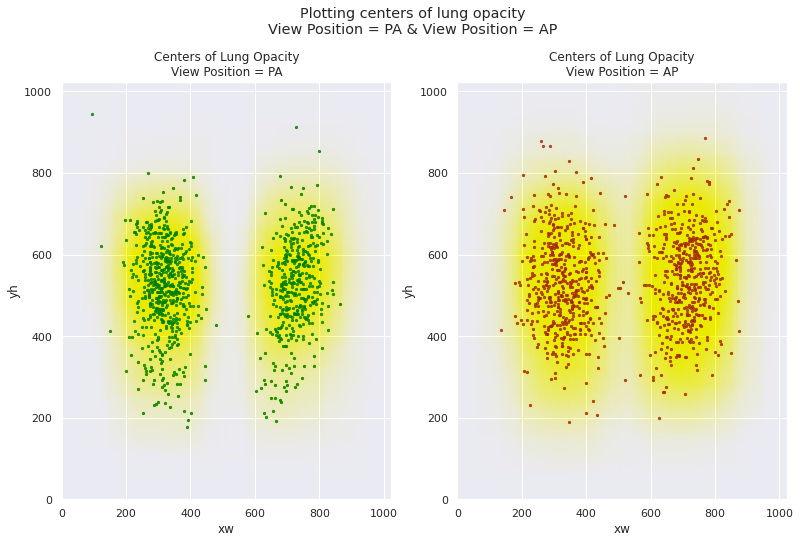

In [24]:
df1 = bounding_boxes[bounding_boxes['ViewPosition'] == 'PA'].sample(1000)
df2 = bounding_boxes[bounding_boxes['ViewPosition'] == 'AP'].sample(1000)
bboxes_scatter(df1, df2, 'View Position = PA', 'View Position = AP')

Let us analyze the distribution of Patients' age and check for outliers

Minimum age: 1.0
Maximum age: 155.0
75th Percentile : 59.0
Age in upper whisker for box plot: 84.0



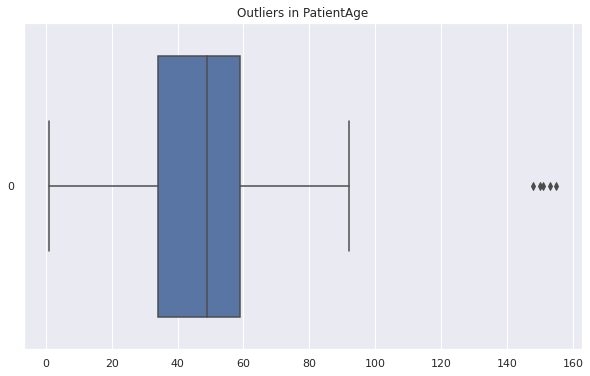

In [25]:
print('Minimum age: {}'.format(train_class['PatientAge'].min()))
print('Maximum age: {}'.format(train_class['PatientAge'].max()))
print('75th Percentile : {}'.format(train_class['PatientAge'].quantile(0.75)))
print('Age in upper whisker for box plot: {}'.format(train_class['PatientAge'].quantile(0.75) + (train_class['PatientAge'].quantile(0.75) - train_class['PatientAge'].quantile(0.25))))
print()
fig = plt.figure(figsize = (10, 6))
ax = sns.boxplot(data = train_class['PatientAge'], orient = 'h').set_title('Outliers in PatientAge')

We can make use of pd.clip() to trim value to a specified lower and upper threshold. So an upper threshold of 100 in PatientAge would mean those outlier values being converted to 100.

In [26]:
train_class['PatientAge'] = train_class['PatientAge'].clip(train_class['PatientAge'].min(), 100)
train_class['PatientAge'].describe().astype(int)

count    30227
mean        46
std         16
min          1
25%         34
50%         49
75%         59
max        100
Name: PatientAge, dtype: int64

Let us get the distribution of PatientAge overall and where there is evidence of Pneumonia

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


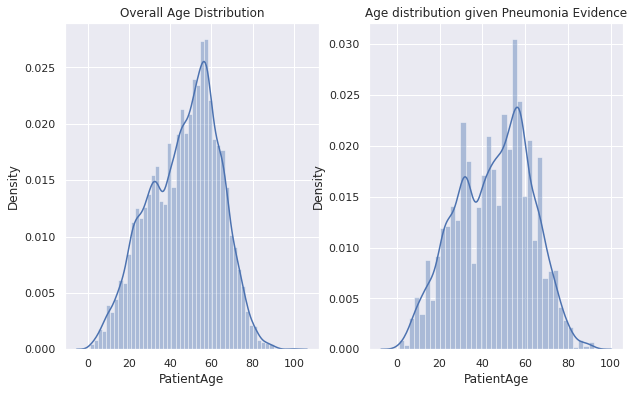

In [27]:
fig = plt.figure(figsize = (10, 6))
ax = fig.add_subplot(121)
g = (sns.distplot(train_class['PatientAge'])
    .set_title('Overall Age Distribution'))
ax = fig.add_subplot(122)
g = (sns.distplot(train_class.loc[train_class['Target'] == 1, 'PatientAge'])
    .set_title('Age distribution given Pneumonia Evidence'))

Let us bin Age values into discrete intervals, used when the need is to segment and sort data values into bins. This takes the Age from a continuous variable to a categorical variable.

In [28]:
train_class['AgeBins'] = pd.cut(train_class['PatientAge'], bins = 4, precision = 0, labels = ['<=26', '<=50', '<=75', '<=100'])
train_class['AgeBins'].value_counts()

<=75     13318
<=50     12157
<=26      3972
<=100      780
Name: AgeBins, dtype: int64

Let's observe the Value counts of the binned Ages

,"Counts of Age Bins, Overall","Counts of Age Bins, Target=1"
<=26,3972,1478
<=50,12157,3917
<=75,13318,3895
<=100,780,265


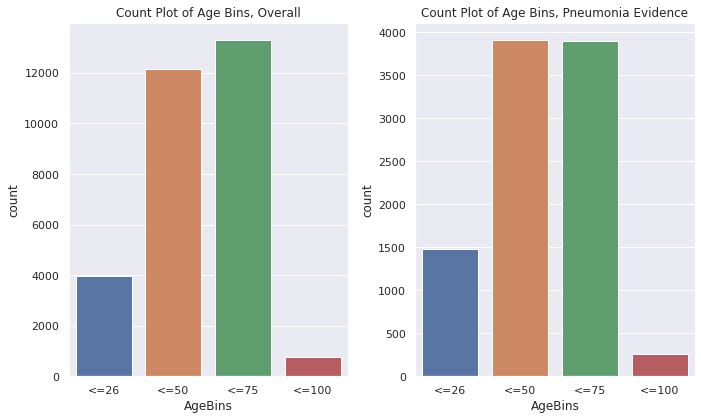

In [29]:
display(pd.concat([train_class['AgeBins'].value_counts().sort_index().rename('Counts of Age Bins, Overall'), 
                   train_class.loc[train_class['Target'] == 1, 'AgeBins'].value_counts().sort_index().rename('Counts of Age Bins, Target=1')], axis = 1))
print()
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 6))
g = sns.countplot(x = train_class['AgeBins'], ax = ax1).set_title('Count Plot of Age Bins, Overall')
g = sns.countplot(x = train_class.loc[train_class['Target'] == 1, 'AgeBins'], ax = ax2).set_title('Count Plot of Age Bins, Pneumonia Evidence')
plt.tight_layout()

We will explore the bounding boxes centers for AgeBins for a random sample

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


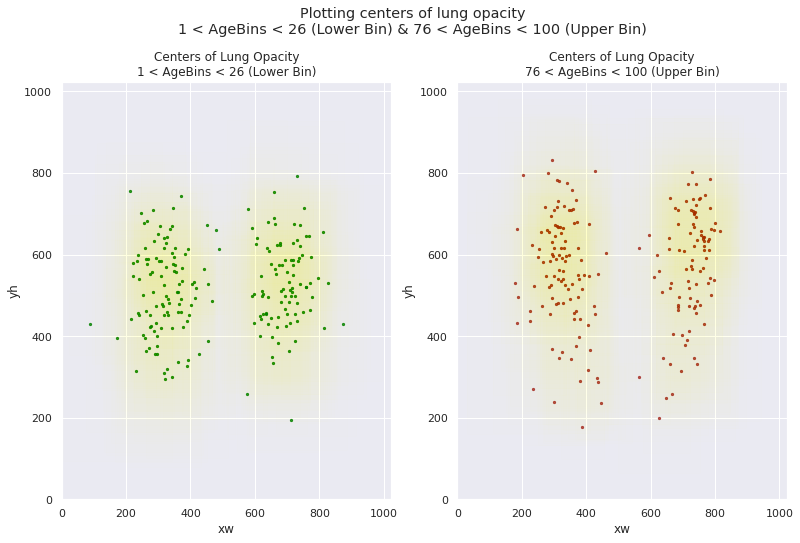

In [30]:
# Creating a dataframe with columns for center of the rectangles
bounding_boxes = train_class[train_class['Target'] == 1]
bounding_boxes['xw'] = bounding_boxes['x'] + bounding_boxes['width'] / 2
bounding_boxes['yh'] = bounding_boxes['y'] + bounding_boxes['height'] / 2

df1 = bounding_boxes[bounding_boxes['AgeBins'] == '<=26'].sample(200)
df2 = bounding_boxes[bounding_boxes['AgeBins'] == '<=100'].sample(200)
bboxes_scatter(df1, df2, '1 < AgeBins < 26 (Lower Bin)', '76 < AgeBins < 100 (Upper Bin)')

Let us check gender-wise distribution for cases with Pneumonia Evidence

,"% Gender, Overall","% Gender, Target=1"
F,0.43,0.42
M,0.57,0.58


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


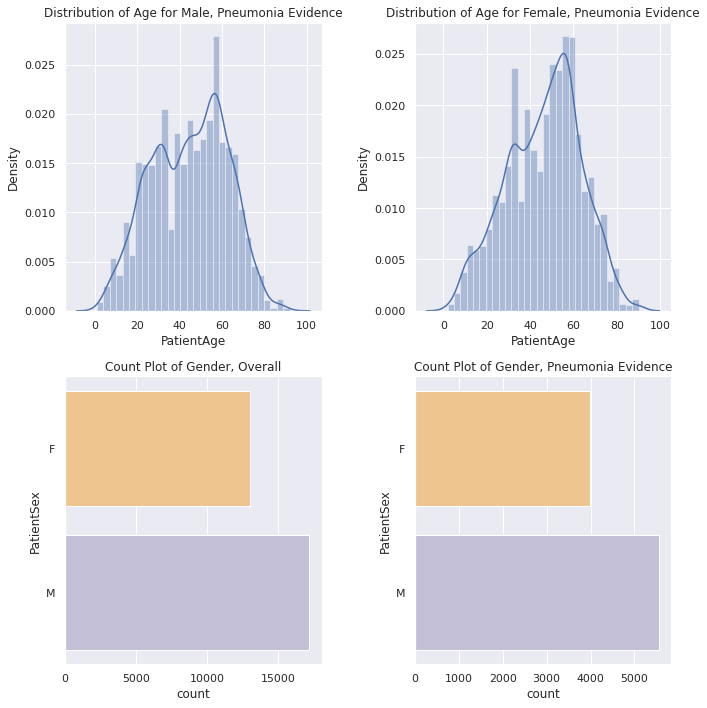

In [31]:
display(pd.concat([train_class['PatientSex'].value_counts(normalize = True).round(2).sort_values().rename('% Gender, Overall'), 
                   train_class.loc[(train_class['Target'] == 1), 'PatientSex']
                   .value_counts(normalize = True).round(2).sort_index().rename('% Gender, Target=1')], axis = 1))

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (10, 10))
g = sns.distplot(train_class.loc[(train_class['Target'] == 1) & (train_class['PatientSex'] == 'M'), 'PatientAge'], ax = ax1).set_title('Distribution of Age for Male, Pneumonia Evidence')
g = sns.distplot(train_class.loc[(train_class['Target'] == 1) & (train_class['PatientSex'] == 'F'), 'PatientAge'], ax = ax2).set_title('Distribution of Age for Female, Pneumonia Evidence')
g = sns.countplot(y = train_class['PatientSex'], ax = ax3, palette = 'PuOr').set_title('Count Plot of Gender, Overall')
g = sns.countplot(y = train_class.loc[(train_class['Target'] == 1), 'PatientSex'], ax = ax4, palette = 'PuOr').set_title('Count Plot of Gender, Pneumonia Evidence')
plt.tight_layout()

Let us explore bounding boxes centers for `PatientSex` for a random sample

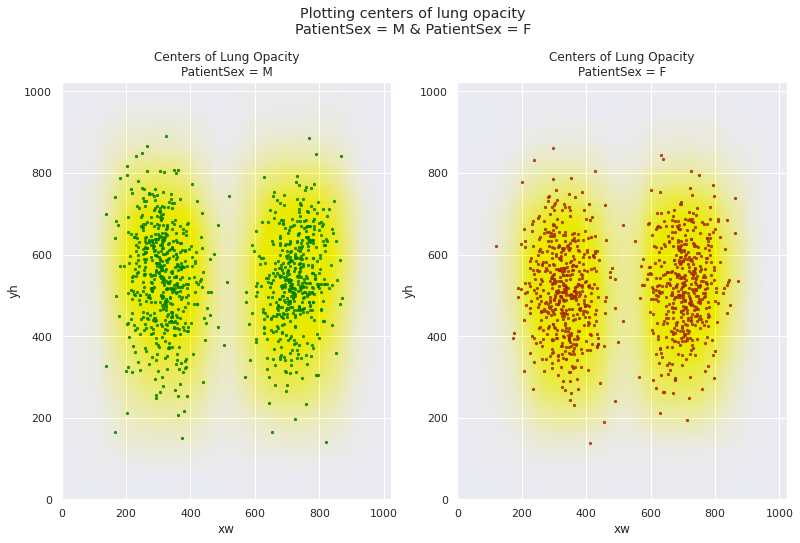

In [32]:
df1 = bounding_boxes[bounding_boxes['PatientSex'] == 'M'].sample(1000)
df2 = bounding_boxes[bounding_boxes['PatientSex'] == 'F'].sample(1000)
bboxes_scatter(df1, df2, 'PatientSex = M', 'PatientSex = F')

In [33]:
train_class.drop(['BodyPartExamined', 'Modality'], inplace = True, axis = 1)
train_class.to_pickle('./output/train_class_features.pkl')
display(train_class.shape, train_class.head())

(30227, 13)

,patientId,x,y,width,height,Target,number_of_boxes,class,path,PatientSex,PatientAge,ViewPosition,AgeBins
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,1,No Lung Opacity / Not Normal,/content/stage_2_train_images/0004cfab-14fd-4e...,F,51.0,PA,<=75
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,1,No Lung Opacity / Not Normal,/content/stage_2_train_images/00313ee0-9eaa-42...,F,48.0,PA,<=50
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,1,No Lung Opacity / Not Normal,/content/stage_2_train_images/00322d4d-1c29-49...,M,19.0,AP,<=26
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,1,Normal,/content/stage_2_train_images/003d8fa0-6bf1-40...,M,28.0,PA,<=50
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,2,Lung Opacity,/content/stage_2_train_images/00436515-870c-4b...,F,32.0,AP,<=50


Check some random samples from training data
Checking some random samples as below:

Different classes i.e. Normal, No Lung Opacity / Not Normal and Lung Opacity
Two view positions that we have in the dataset
For the one with Pneumonia Evidence and age = 92
Now, we will make use of custom module (eda) and function (plot_dicom_images) already imported earlier to visualize the images.

Checking sample for different classes


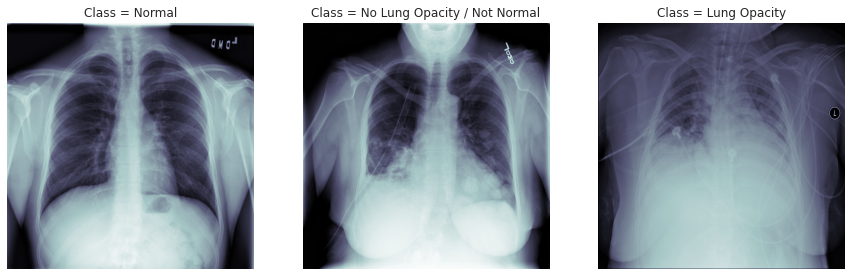

In [34]:
print('Checking sample for different classes')
sample1 = train_class.loc[train_class['class'] == 'Normal'].iloc[0]
sample2 = train_class.loc[train_class['class'] == 'No Lung Opacity / Not Normal'].iloc[0]
sample3 = train_class.loc[train_class['class'] == 'Lung Opacity'].iloc[1]
ds1 = dcm.dcmread(sample1['path'])
ds2 = dcm.dcmread(sample2['path'])
ds3 = dcm.dcmread(sample3['path'])

f, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize = (15, 8))
ax1.imshow(ds1.pixel_array, cmap = plt.cm.bone)
ax1.set_title('Class = Normal')
ax1.axis('off')
ax2.imshow(ds2.pixel_array, cmap = plt.cm.bone)
ax2.set_title('Class = No Lung Opacity / Not Normal')
ax2.axis('off')
ax3.imshow(ds3.pixel_array, cmap = plt.cm.bone)
ax3.set_title('Class = Lung Opacity')
ax3.axis('off')
plt.show()

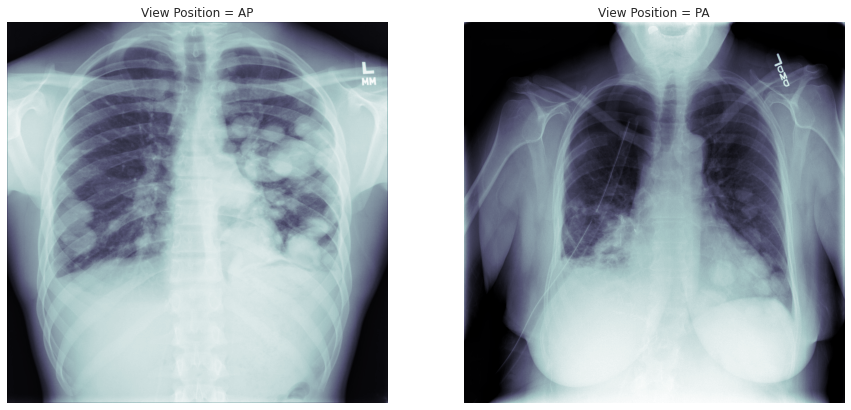

In [35]:
sample4 = train_class.loc[(train_class['ViewPosition'] == 'AP')].iloc[0]
sample5 = train_class.loc[(train_class['ViewPosition'] == 'PA')].iloc[0]
ds4 = dcm.dcmread(sample4['path'])
ds5 = dcm.dcmread(sample5['path'])

f, ((ax1, ax2)) = plt.subplots(1, 2, figsize = (15, 8))
ax1.imshow(ds4.pixel_array, cmap = plt.cm.bone)
ax1.set_title('View Position = AP')
ax1.axis('off')
ax2.imshow(ds5.pixel_array, cmap = plt.cm.bone)
ax2.set_title('View Position = PA')
ax2.axis('off')
plt.show()

In [36]:
# Helper function to plot the dicom images
def plot_dicom_images(data, df, img_path):
    img_data = list(data.T.to_dict().values())
    f, ax = plt.subplots(3, 3, figsize = (16, 18))
    for i, row in enumerate(img_data):
        image = row['patientId'] + '.dcm'
        path = os.path.join(img_path, image)
        data = dcm.read_file(path)
        rows = df[df['patientId'] == row['patientId']]
        age = rows.PatientAge.unique().tolist()[0]
        sex = data.PatientSex
        part = data.BodyPartExamined
        vp = data.ViewPosition
        modality = data.Modality
        data_img = dcm.dcmread(path)
        ax[i//3, i%3].imshow(data_img.pixel_array, cmap = plt.cm.bone)
        ax[i//3, i%3].axis('off')
        ax[i//3, i%3].set_title('ID: {}\nAge: {}, Sex: {}, Part: {}, VP: {}, Modality: {}\nTarget: {}, Class: {}\nWindow: {}:{}:{}:{}'\
                              .format(row['patientId'], age, sex, part, 
                                      vp, modality, row['Target'], 
                                      row['class'], row['x'], 
                                      row['y'], row['width'],
                                      row['height']))
        box_data = list(rows.T.to_dict().values())
        for j, row in enumerate(box_data):
            ax[i//3, i%3].add_patch(Rectangle(xy = (row['x'], row['y']),
                      width = row['width'], height = row['height'], 
                      color = 'blue', alpha = 0.15)) 
    plt.show()

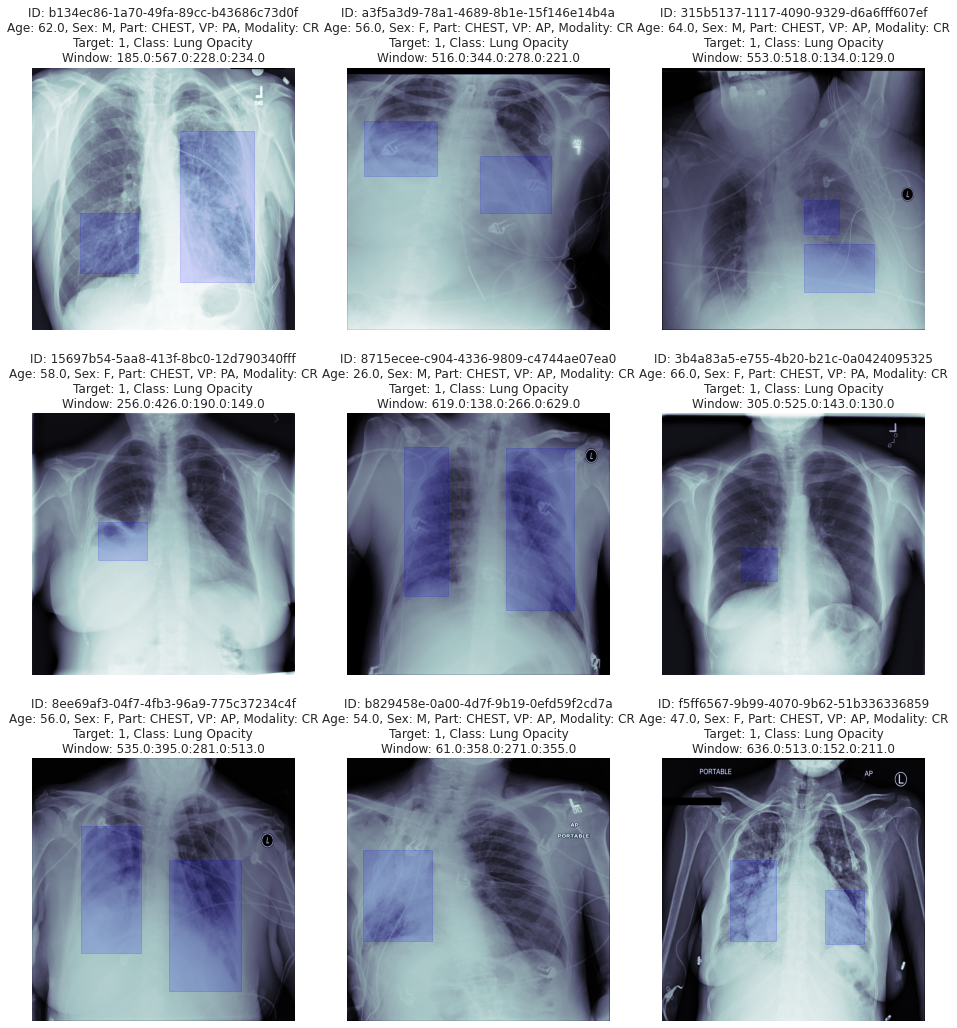

In [37]:
plot_dicom_images(data = train_class.loc[(train_class['Target'] == 1)].sample(9), 
                  df = train_class, img_path = train_imgs)

## Model Building using Mask R-CNN

In [38]:
print(train_imgs)
filenames = {}

save_path = os.path.join(data_folder + 'saved_data/')


read_directory = False
if(read_directory):
  filenames = os.listdir(train_imgs)
  pd.DataFrame(filenames).to_csv(save_path+'train_path_listdir.csv')
else:
  filenames=pd.read_csv(save_path+'train_path_listdir.csv', usecols=[1],header=0).values.tolist()
  filenames = [val for sublist in filenames for val in sublist]

/content/stage_2_train_images/


FileNotFoundError: ignored